In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

In [3]:
fields_to_skip = ["meta", "info"]

In [4]:
def populate_wicket_data(idx, delivery):
    wicket_record = {}
    if "wickets" in delivery and delivery["wickets"]:
        for wicket in delivery["wickets"]:
            wicket_record = {
                "delivery_index": idx,
                "wicket.kind": wicket["kind"],
                "wicket.player_out": wicket["player_out"],
                "wicket.fielders": (
                    [fielder["name"] for fielder in wicket["fielders"]]
                    if wicket.get("fielders") != None
                    else None
                ),
            }
    else:
        wicket_record = {
            "delivery_index": idx,
            "wicket.kind": None,
            "wicket.player_out": None,
            "wicket.fielders": None,
        }
    return wicket_record

In [5]:
file_names = os.listdir(path="data")
file_names = filter(lambda x: str(x).endswith(".json"), file_names)

merged_deliveries = pd.DataFrame()
wickets_data = []
index = 0
match_number = 1

# file_names = ["829813.json", "829817.json", "829823.json"]

for file_idx, file_name in enumerate(file_names):
    file_path = "data/" + file_name
    with open(file=file_path, mode="r") as file:
        print("processing file: ", file_idx, file_name, sep=", ")
        data = json.load(file)
        info = data["info"]
        date = info["dates"][0]
        match_number = (
            info["event"].get("match_number")
            if info["event"].get("match_number") != None
            else info["event"].get("stage")
        )
        innings = data["innings"]
        for idx, inning in enumerate(innings):
            if inning.get("super_over") is not None:
                print("skipping super_over: ", date, match_number)
                continue
            overs = inning["overs"]
            df_deliveries = pd.json_normalize(
                overs, record_path=["deliveries"], meta=["over"]
            )
            df_deliveries["date"] = date
            df_deliveries["match_number"] = match_number
            df_deliveries["innings"] = idx + 1
            merged_deliveries = pd.concat([merged_deliveries, df_deliveries], axis=0)
            for over in overs:
                for delivery in over["deliveries"]:
                    wicket_data = populate_wicket_data(index, delivery)
                    wickets_data.append(wicket_data)
                    index += 1

df_wickets = pd.DataFrame(wickets_data)

merged_deliveries.reset_index(inplace=True)

merged_deliveries["delivery_index"] = merged_deliveries.index

df_merged = pd.merge(merged_deliveries, df_wickets, on="delivery_index", how="left")

df_merged.drop("delivery_index", inplace=True, axis=1)
# df_merged.drop("wickets", inplace=True, axis=1)

processing file: , 0, 1254103.json
processing file: , 1, 1136605.json
processing file: , 2, 1216501.json
processing file: , 3, 1082595.json
processing file: , 4, 829731.json
processing file: , 5, 1359507.json
processing file: , 6, 548315.json
processing file: , 7, 1304079.json
processing file: , 8, 1422119.json
processing file: , 9, 1178418.json
processing file: , 10, 1359487.json
processing file: , 11, 1359515.json
processing file: , 12, 336025.json
processing file: , 13, 729309.json
processing file: , 14, 1178407.json
processing file: , 15, 501239.json
processing file: , 16, 1178423.json
processing file: , 17, 1426305.json
processing file: , 18, 419107.json
processing file: , 19, 336036.json
processing file: , 20, 1426311.json
processing file: , 21, 1082637.json
processing file: , 22, 392232.json
processing file: , 23, 1216522.json
processing file: , 24, 1426307.json
processing file: , 25, 829713.json
processing file: , 26, 1136576.json
processing file: , 27, 1359498.json
processing 

In [6]:
ordered_cols = [
    "date",
    "match_number",
    "innings",
    "over",
    "batter",
    "bowler",
    "non_striker",
    "runs.batter",
    "runs.extras",
    "runs.total",
    "extras.legbyes",
    "extras.wides",
    "extras.byes",
    "extras.noballs",
    "wicket.kind",
    "wicket.player_out",
    "wicket.fielders",
    "wickets",
]

In [7]:
df_merged = df_merged.reindex(columns=ordered_cols)
df_merged.sort_values(by=["date", "match_number"], inplace=True)

In [8]:
df_wickets.to_csv("output/wickets.csv", index=False)

In [9]:
df_merged.to_csv("output/ipl_ball_by_ball_output.csv", index=False)

In [10]:
df_merged.head()

,date,match_number,innings,over,batter,bowler,non_striker,runs.batter,runs.extras,runs.total,extras.legbyes,extras.wides,extras.byes,extras.noballs,wicket.kind,wicket.player_out,wicket.fielders,wickets
79344,2008-04-18,1,1,0,SC Ganguly,P Kumar,BB McCullum,0,1,1,1.0,NaN,NaN,NaN,None,None,None,NaN
79345,2008-04-18,1,1,0,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,None,None,None,NaN
79346,2008-04-18,1,1,0,BB McCullum,P Kumar,SC Ganguly,0,1,1,NaN,1.0,NaN,NaN,None,None,None,NaN
79347,2008-04-18,1,1,0,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,None,None,None,NaN
79348,2008-04-18,1,1,0,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,None,None,None,NaN


## Validate the resultant dataframe


In [11]:
print("min date: ", df_merged["date"].min())
print("max date: ", df_merged["date"].max())

min date:  2008-04-18
max date:  2024-05-26


### Since we have data for IPL matches between 2008 to 2024, the above date range looks right


In [12]:
df_merged["match_number"].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 'Semi Final', 'Final', 47, '3rd Place Play-Off', 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 'Qualifier 1',
       'Elimination Final', 'Qualifier 2', 71, 72, 'Eliminator'],
      dtype=object)

### The above values for match_number looks right


In [13]:
df_merged["innings"].unique()

array([1, 2])

In [14]:
df_merged["over"].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19], dtype=object)

In [15]:
sorted(df_merged["runs.batter"].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6)]

In [16]:
sorted(df_merged["runs.extras"].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(7)]

In [17]:
sorted(df_merged["runs.total"].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7)]

In [18]:
sorted(df_merged["extras.legbyes"].unique())

[np.float64(1.0),
 np.float64(nan),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(4.0),
 np.float64(5.0)]

In [19]:
sorted(df_merged["extras.wides"].unique())

[np.float64(nan),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(4.0),
 np.float64(5.0)]

In [20]:
sorted(df_merged["extras.byes"].unique())

[np.float64(nan),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(4.0)]

In [21]:
sorted(df_merged["extras.noballs"].unique())

[np.float64(nan),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(5.0)]

In [22]:
df_merged["wicket.kind"].unique()

array([None, 'caught', 'bowled', 'run out', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field', 'retired out'], dtype=object)

In [23]:
df_merged["wicket.player_out"].unique()[:10]

array([None, 'SC Ganguly', 'RT Ponting', 'DJ Hussey', 'R Dravid',
       'V Kohli', 'JH Kallis', 'W Jaffer', 'MV Boucher', 'B Akhil'],
      dtype=object)

In [24]:
df_merged[~pd.isnull(df_merged["wicket.fielders"])]["wicket.fielders"].count()

np.int64(9342)

In [25]:
df_merged[~ pd.isnull(df_merged["wickets"])]['wickets'].count()

np.int64(12923)

In [26]:
df_merged

,date,match_number,innings,over,batter,bowler,non_striker,runs.batter,runs.extras,runs.total,extras.legbyes,extras.wides,extras.byes,extras.noballs,wicket.kind,wicket.player_out,wicket.fielders,wickets
79344,2008-04-18,1,1,0,SC Ganguly,P Kumar,BB McCullum,0,1,1,1.0,NaN,NaN,NaN,None,None,None,NaN
79345,2008-04-18,1,1,0,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,None,None,None,NaN
79346,2008-04-18,1,1,0,BB McCullum,P Kumar,SC Ganguly,0,1,1,NaN,1.0,NaN,NaN,None,None,None,NaN
79347,2008-04-18,1,1,0,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,None,None,None,NaN
79348,2008-04-18,1,1,0,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52721,2024-05-26,Final,2,9,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,NaN,NaN,NaN,None,None,None,NaN
52722,2024-05-26,Final,2,9,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,NaN,NaN,NaN,None,None,None,NaN
52723,2024-05-26,Final,2,10,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,NaN,NaN,NaN,None,None,None,NaN
52724,2024-05-26,Final,2,10,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,NaN,NaN,NaN,None,None,None,NaN


In [27]:
df_merged['season'] = df_merged['date'].str.slice(0,4)

In [28]:
df_merged

,date,match_number,innings,over,batter,bowler,non_striker,runs.batter,runs.extras,runs.total,extras.legbyes,extras.wides,extras.byes,extras.noballs,wicket.kind,wicket.player_out,wicket.fielders,wickets,season
79344,2008-04-18,1,1,0,SC Ganguly,P Kumar,BB McCullum,0,1,1,1.0,NaN,NaN,NaN,None,None,None,NaN,2008
79345,2008-04-18,1,1,0,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,None,None,None,NaN,2008
79346,2008-04-18,1,1,0,BB McCullum,P Kumar,SC Ganguly,0,1,1,NaN,1.0,NaN,NaN,None,None,None,NaN,2008
79347,2008-04-18,1,1,0,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,None,None,None,NaN,2008
79348,2008-04-18,1,1,0,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,NaN,NaN,NaN,None,None,None,NaN,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52721,2024-05-26,Final,2,9,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,NaN,NaN,NaN,None,None,None,NaN,2024
52722,2024-05-26,Final,2,9,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,NaN,NaN,NaN,None,None,None,NaN,2024
52723,2024-05-26,Final,2,10,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,NaN,NaN,NaN,None,None,None,NaN,2024
52724,2024-05-26,Final,2,10,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,NaN,NaN,NaN,None,None,None,NaN,2024


In [29]:
df_merged.drop(columns='wickets',inplace=True)

In [30]:
df_merged.groupby(['date','match_number','innings','batter']).agg({'runs.batter':np.sum,'runs.extras':np.sum,'bowler':'count'})

/tmp/ipykernel_288374/19595509.py:1: FutureWarning: The provided callable <function sum at 0x7edf983349d0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_merged.groupby(['date','match_number','innings','batter']).agg({'runs.batter':np.sum,'runs.extras':np.sum,'bowler':'count'})
/tmp/ipykernel_288374/19595509.py:1: FutureWarning: The provided callable <function sum at 0x7edf983349d0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_merged.groupby(['date','match_number','innings','batter']).agg({'runs.batter':np.sum,'runs.extras':np.sum,'bowler':'count'})


runs.batter  runs.extras  \
date       match_number innings batter                                         
2008-04-18 1            1       BB McCullum                 158           11   
                                DJ Hussey                    12            0   
                                Mohammad Hafeez               5            0   
                                RT Ponting                   20            4   
                                SC Ganguly                   10            2   
...                                                         ...          ...   
2024-05-26 Final        1       TM Head                       0            0   
                        2       Rahmanullah Gurbaz           39            7   
                                SP Narine                     6            0   
                                SS Iyer                       6            0   
                                VR Iyer                      52            4   

                                                    bowler  
date       match_number innings batter                      
2008-04-18 1            1       BB McCullum             77  
                                DJ Hussey               12  
                                Mohammad Hafeez          3  
                                RT Ponting              20  
                                SC Ganguly              12  
...                                                    ...  
2024-05-26 Final        1       TM Head                  1  
                        2       Rahmanullah Gurbaz      35  
                                SP Narine                2  
                                SS Iyer                  3  
                                VR Iyer                 27  

[16515 rows x 3 columns]

In [31]:
df_merged.groupby(['date','match_number','innings','bowler','runs.batter']).agg({'runs.total':'sum','wicket.kind':'count','batter':'count'})

runs.total  \
date       match_number innings bowler        runs.batter               
2008-04-18 1            1       AA Noffke     0                     6   
                                              1                    11   
                                              2                     4   
                                              4                     8   
                                              6                    12   
...                                                               ...   
2024-05-26 Final        2       Shahbaz Ahmed 6                    12   
                                T Natarajan   0                     2   
                                              1                     5   
                                              4                    16   
                                              6                     6   

                                                           wicket.kind  batter  
date       match_number innings bowler        runs.batter                       
2008-04-18 1            1       AA Noffke     0                      1       8  
                                              1                      0      11  
                                              2                      0       2  
                                              4                      0       2  
                                              6                      0       2  
...                                                                ...     ...  
2024-05-26 Final        2       Shahbaz Ahmed 6                      0       2  
                                T Natarajan   0                      0       4  
                                              1                      0       5  
                                              4                      0       4  
                                              6                      0       1  

[54044 rows x 3 columns]

In [32]:
batter_total = df_merged.groupby(['batter','season',]).agg({'runs.total':['sum',np.average],'bowler':'max'})
batter_total

runs.total                     bowler
                             sum   average              max
batter         season                                      
A Ashish Reddy 2012           40  1.333333          SW Tait
               2013          126  1.400000         UT Yadav
               2015           74  1.608696       TG Southee
               2016           48  1.600000        YS Chahal
A Badoni       2022          173  1.244604        YS Chahal
...                          ...       ...              ...
Z Khan         2011           21  0.875000        SB Jakati
               2012           12  0.705882  Shakib Al Hasan
               2014           10  1.428571        IK Pathan
               2016            6  0.461538        PP Chawla
               2017            4  0.307692           P Negi

[2617 rows x 3 columns]

In [33]:
batter_total.columns

MultiIndex([('runs.total',     'sum'),
            ('runs.total', 'average'),
            (    'bowler',     'max')],
           )

In [34]:
batter_scores_count = df_merged.groupby(['batter','season','runs.batter']).agg({'runs.total':['sum','count']})

In [35]:
batter_scores_count

runs.total      
                                         sum count
batter         season runs.batter                 
A Ashish Reddy 2012   0                    5    13
                      1                    9     9
                      2                    8     4
                      4                   12     3
                      6                    6     1
...                                      ...   ...
Z Khan         2016   0                    0    10
                      1                    2     2
                      4                    4     1
               2017   0                    0     9
                      1                    4     4

[11075 rows x 2 columns]

In [79]:
vk1 =batter_scores_count.loc['V Kohli'].reset_index()
vk2 = batter_total.loc['V Kohli'].reset_index()
vk1.columns = ['_'.join(col) for col in vk1.columns]
vk2.columns = ['_'.join(col) for col in vk2.columns]
vk1['season_'] =  vk1.season_.astype(int)
vk2['season_'] =  vk2.season_.astype(int)
vk1.rename(columns={'runs.total_sum':'total_runs_per_score','runs.total_count':'no_of_balls','season_':'season'},inplace=True)
vk2.rename(columns={'season_': 'season'}, inplace=True)
print(vk1.info())
print(vk2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   season                97 non-null     int64
 1   runs.batter_          97 non-null     int64
 2   total_runs_per_score  97 non-null     int64
 3   no_of_balls           97 non-null     int64
dtypes: int64(4)
memory usage: 3.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   season              17 non-null     int64  
 1   runs.total_sum      17 non-null     int64  
 2   runs.total_average  17 non-null     float64
 3   bowler_max          17 non-null     object 
dtypes: float64(1), int64(2), object(1)
memory usage: 672.0+ bytes
None


In [92]:
vk1.head(10)

,season,runs.batter_,total_runs_per_score,no_of_balls
0,2008,0,22,82
1,2008,1,59,59
2,2008,2,10,5
3,2008,4,72,18
4,2008,6,24,4
5,2009,0,12,98
6,2009,1,84,84
7,2009,2,26,13
8,2009,4,88,22
9,2009,6,48,8


In [89]:

print(vk1.dtypes)
print(vk2.dtypes)
# v_kohli = vk1.join(vk2,on='season',lsuffix='_')
v_kohli = pd.merge(vk1, vk2, how="inner", on="season")
# v_kohli.columns = ['_'.join(col) for col in v_kohli.columns]

season                  int64
runs.batter_            int64
total_runs_per_score    int64
no_of_balls             int64
dtype: object
season                  int64
runs.total_sum          int64
runs.total_average    float64
bowler_max             object
dtype: object


In [90]:
v_kohli.head(20)

,season,runs.batter_,total_runs_per_score,no_of_balls,runs.total_sum,runs.total_average,bowler_max
0,2008,0,22,82,187,1.113095,WPUJC Vaas
1,2008,1,59,59,187,1.113095,WPUJC Vaas
2,2008,2,10,5,187,1.113095,WPUJC Vaas
3,2008,4,72,18,187,1.113095,WPUJC Vaas
4,2008,6,24,4,187,1.113095,WPUJC Vaas
5,2009,0,12,98,258,1.146667,Yuvraj Singh
6,2009,1,84,84,258,1.146667,Yuvraj Singh
7,2009,2,26,13,258,1.146667,Yuvraj Singh
8,2009,4,88,22,258,1.146667,Yuvraj Singh
9,2009,6,48,8,258,1.146667,Yuvraj Singh


In [75]:
vk2.head()

,season_,runs.total_sum,runs.total_average,bowler_max
0,2008,187,1.113095,WPUJC Vaas
1,2009,258,1.146667,Yuvraj Singh
2,2010,320,1.481481,Z Khan
3,2011,584,1.234672,Yuvraj Singh
4,2012,375,1.126126,YK Pathan


In [66]:

v_kohli


,season__,total_runs_per_score,runs.total_average,bowler_max,season_,runs.batter_,runs.total_sum,runs.total_count


In [131]:
bowler_perf = df_merged.groupby(['bowler','season','wicket.kind']).agg({'wicket.player_out':['count'],'batter':['max']})

In [133]:
bowler_perf

wicket.player_out        batter
                                                    count           max
bowler         season wicket.kind                                      
A Ashish Reddy 2012   bowled                            2    RV Uthappa
                      caught                            7       V Kohli
                      lbw                               2       N Saini
               2013   bowled                            2   LRPL Taylor
                      caught and bowled                 1       V Kohli
...                                                   ...           ...
Z Khan         2016   lbw                               1     PP Chawla
                      run out                           2      UT Yadav
               2017   bowled                            1     AM Rahane
                      caught                            9       V Kohli
                      run out                           2  Vishnu Vinod

[4241 rows x 2 columns]

In [94]:

from plotter import gapminder,parallelplot

In [97]:

gapminder(v_kohli, v_kohli['season'], v_kohli['runs.total_sum'],
          v_kohli['runs.total_average']**5, v_kohli["bowler_max"] ,labels={'runs.total_sum':'Total runs','season_':"Season"},title='Virat Batting Perf')


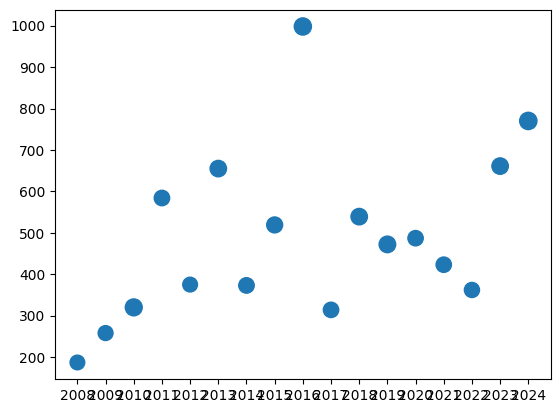

In [57]:
plt.scatter(x=v_kohli['season'],y=v_kohli['runs.total']['sum'],s=v_kohli['runs.total']['average']*100)

In [107]:
parallelplot(v_kohli,columns=[v_kohli['runs.total_sum'],v_kohli['runs.batter_'],v_kohli['total_runs_per_score'],v_kohli['no_of_balls']],title="Kohli Parallel",color_col=v_kohli['season'])